Starting integration benchmark...
Running integration benchmarks...
Size       CPU Trap (s)    GPU Trap (s)    CPU Analytical (s) GPU Analytical (s)
100        0.000024        0.000332        0.000039        0.000507       
1000       0.000030        0.000293        0.000040        0.000530       
10000      0.000068        0.000334        0.000043        0.000586       
100000     0.000365        0.000493        0.000052        0.001184       
1000000    0.003652        0.002747        0.000041        0.007946       
10000000   0.096735        0.040723        0.000042        0.110336       


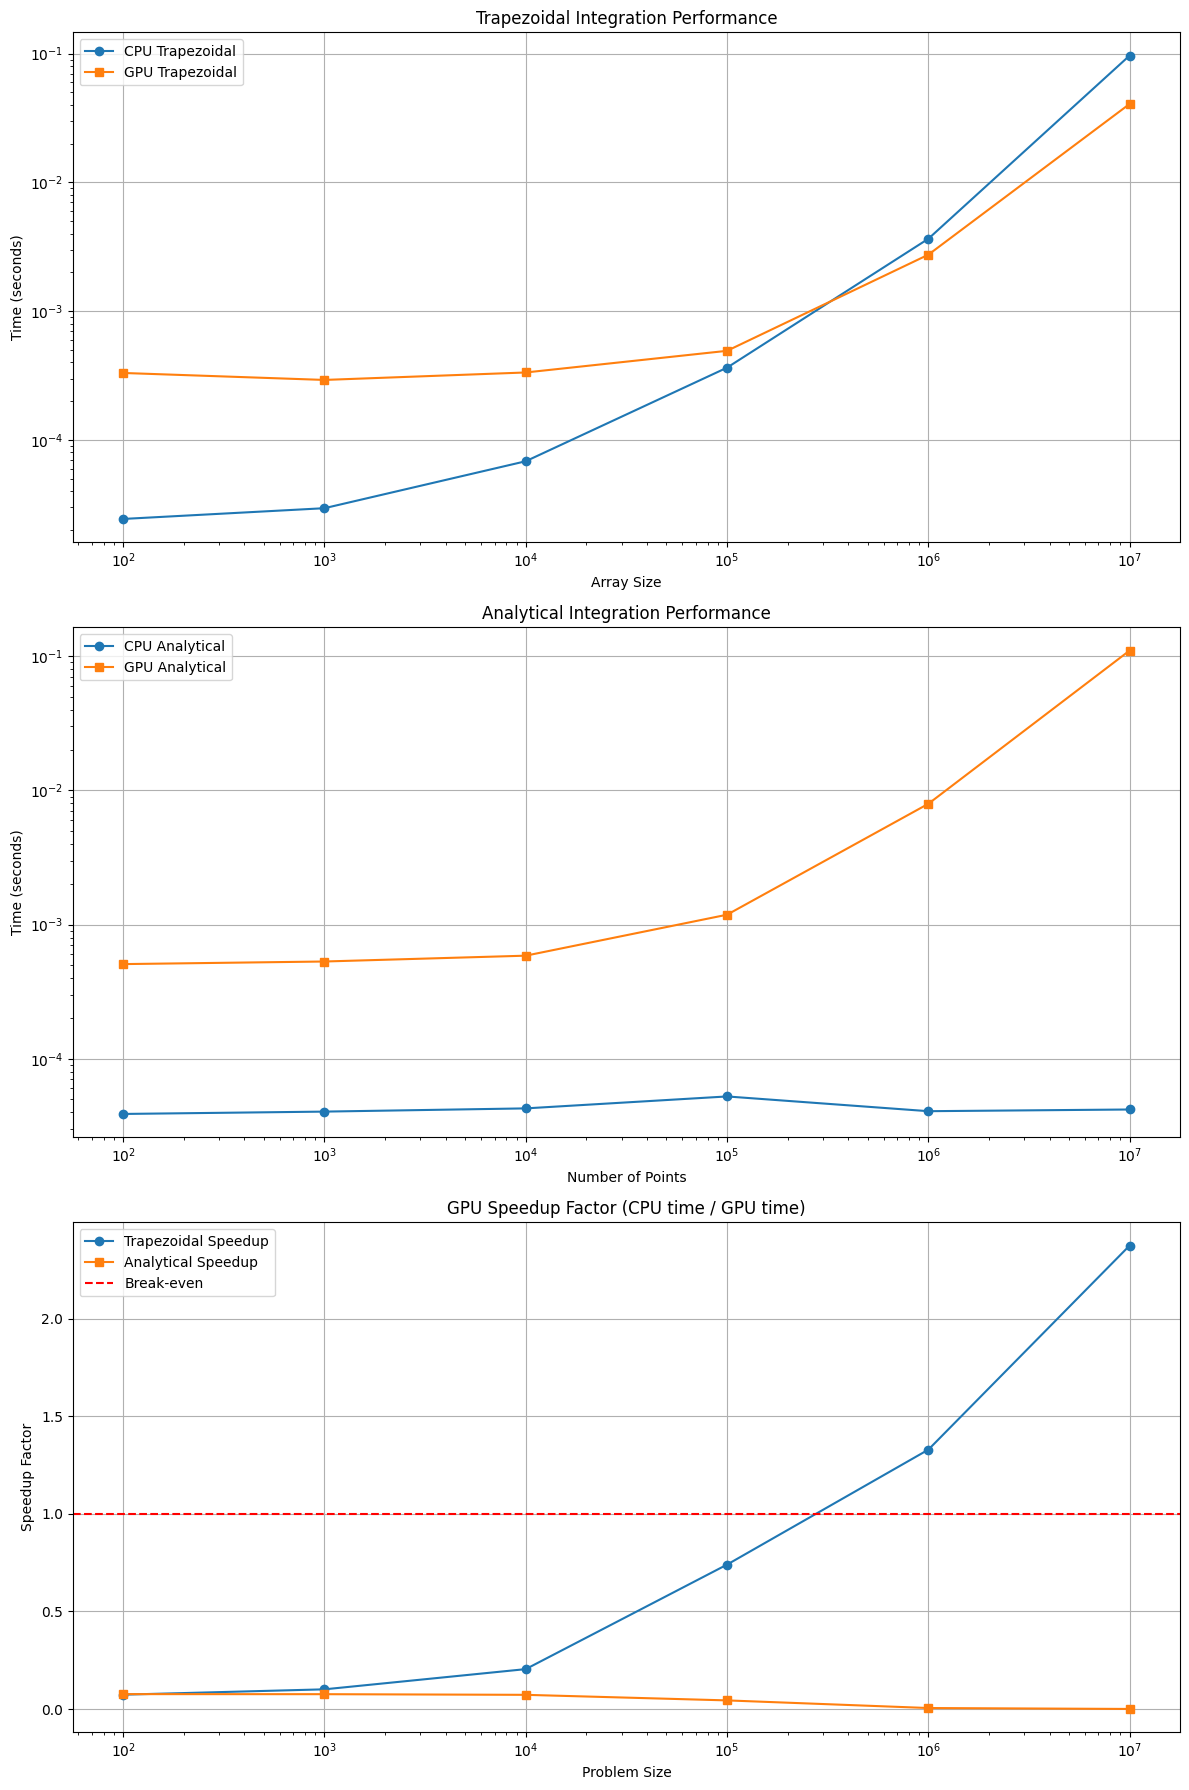

Benchmark complete. Results saved to integration_benchmark_results.png


In [14]:
# -*- coding: utf-8 -*-
"""integration_benchmark.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1x0VH_nCuqcN8A0cR0euo_g9cr4ZeQ2tN
"""

import zipfile
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt


with zipfile.ZipFile("/content/GPUPy.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

sys.path.append("/content")

try:
    import cupy as cp
    _CUPY_AVAILABLE = True
except ImportError:
    _CUPY_AVAILABLE = False
    print("Warning: CuPy not found. GPU benchmarks will be skipped.")

from GPUPy.src.numerical_methods.integration import trapezoidal_integral, analytical_integral
def benchmark(method_func, *args, repeats=5, **kwargs):
    """
    Benchmark a function by measuring its execution time.

    Parameters:
        method_func (callable): Function to benchmark
        *args: Positional arguments to pass to the function
        repeats (int): Number of times to repeat the measurement
        **kwargs: Keyword arguments to pass to the function

    Returns:
        float: Average execution time in seconds
    """

    method_func(*args, **kwargs)


    durations = []
    for _ in range(repeats):
        start = time.perf_counter()
        method_func(*args, **kwargs)
        durations.append(time.perf_counter() - start)

    avg_time = sum(durations) / repeats
    return avg_time

def plot_benchmark_results(sizes, cpu_times_trap, gpu_times_trap,
                           cpu_times_analytical, gpu_times_analytical,
                           speedup_trap, speedup_analytical):
    """
    Create visualization of benchmark results.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

    # Plot 1: Execution times for trapezoidal integration
    ax1.plot(sizes, cpu_times_trap, 'o-', label='CPU Trapezoidal')
    ax1.plot(sizes, gpu_times_trap, 's-', label='GPU Trapezoidal')
    ax1.set_title('Trapezoidal Integration Performance')
    ax1.set_xlabel('Array Size')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid(True)
    ax1.legend()

    # Plot 2: Execution times for analytical integration
    ax2.plot(sizes, cpu_times_analytical, 'o-', label='CPU Analytical')
    ax2.plot(sizes, gpu_times_analytical, 's-', label='GPU Analytical')
    ax2.set_title('Analytical Integration Performance')
    ax2.set_xlabel('Number of Points')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid(True)
    ax2.legend()

    # Plot 3: Speedup
    ax3.plot(sizes, speedup_trap, 'o-', label='Trapezoidal Speedup')
    ax3.plot(sizes, speedup_analytical, 's-', label='Analytical Speedup')
    ax3.axhline(y=1, color='r', linestyle='--', label='Break-even')
    ax3.set_title('GPU Speedup Factor (CPU time / GPU time)')
    ax3.set_xlabel('Problem Size')
    ax3.set_ylabel('Speedup Factor')
    ax3.set_xscale('log')
    ax3.grid(True)
    ax3.legend()

    plt.tight_layout()
    plt.savefig('integration_benchmark_results.png')
    plt.show()

# --- Main Benchmark Runner Function ---
def run_integration_benchmarks():
    """
    Run benchmarks comparing CPU and GPU integration performance
    for different problem sizes.
    """
    # Test function to integrate
    def test_func(x):
        # Use xp for array module flexibility (np or cp)
        xp = cp.get_array_module(x) if _CUPY_AVAILABLE and isinstance(x, cp.ndarray) else np
        return xp.sin(x) * xp.exp(-0.1 * x)

    # Define problem sizes to test - ADDED 10 MILLION HERE
    sizes = [100, 1000, 10000, 100000, 1000000, 10000000]

    # Storage for results
    cpu_times_trap = []
    gpu_times_trap = []
    cpu_times_analytical = []
    gpu_times_analytical = []

    print("Running integration benchmarks...")
    print("{:<10} {:<15} {:<15} {:<15} {:<15}".format(
        "Size", "CPU Trap (s)", "GPU Trap (s)", "CPU Analytical (s)", "GPU Analytical (s)"))

    # Run benchmarks for each size
    for size in sizes:
        # Create data for trapezoidal rule
        x = np.linspace(0, 10, size)
        y = test_func(x) # y for numpy array

        # Benchmark trapezoidal integration
        cpu_time_trap = benchmark(trapezoidal_integral, x, y, use_gpu=False)
        cpu_times_trap.append(cpu_time_trap)

        gpu_time_trap = 0.0 # Default to 0 if GPU not available
        if _CUPY_AVAILABLE:
            # For trapezoidal_integral, pass NumPy arrays and let it handle conversion
            gpu_time_trap = benchmark(trapezoidal_integral, x, y, use_gpu=True)
        else:
            print(f"Skipping GPU trapezoidal benchmark for size {size} (CuPy not available).")
        gpu_times_trap.append(gpu_time_trap)


        # Benchmark analytical integration
        # For analytical_integral, func will receive np or cp array depending on use_gpu
        cpu_time_analytical = benchmark(analytical_integral, test_func, 0, 10, use_gpu=False)
        cpu_times_analytical.append(cpu_time_analytical)

        gpu_time_analytical = 0.0 # Default to 0 if GPU not available
        if _CUPY_AVAILABLE:
            gpu_time_analytical = benchmark(analytical_integral, test_func, 0, 10,
                                            use_gpu=True, num_points=size)
        else:
            print(f"Skipping GPU analytical benchmark for size {size} (CuPy not available).")
        gpu_times_analytical.append(gpu_time_analytical)


        # Print results for current size
        print("{:<10} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}".format(
            size, cpu_time_trap, gpu_time_trap, cpu_time_analytical, gpu_time_analytical))

    # Calculate speedup
    speedup_trap = [cpu/gpu if gpu > 0 else np.nan for cpu, gpu in zip(cpu_times_trap, gpu_times_trap)]
    speedup_analytical = [cpu/gpu if gpu > 0 else np.nan for cpu, gpu in zip(cpu_times_analytical, gpu_times_analytical)]

    # Plot results
    plot_benchmark_results(sizes, cpu_times_trap, gpu_times_trap,
                           cpu_times_analytical, gpu_times_analytical,
                           speedup_trap, speedup_analytical)

    return {
        'sizes': sizes,
        'cpu_times_trap': cpu_times_trap,
        'gpu_times_trap': gpu_times_trap,
        'cpu_times_analytical': cpu_times_analytical,
        'gpu_times_analytical': gpu_times_analytical,
        'speedup_trap': speedup_trap,
        'speedup_analytical': speedup_analytical
    }

# --- Main execution block ---
if __name__ == "__main__":
    print("Starting integration benchmark...")
    results = run_integration_benchmarks()
    print("Benchmark complete. Results saved to integration_benchmark_results.png")